# Imports

In [ ]:
import os

if 'models' not in os.listdir('.'): 
    !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

**Download images and annotations** \
Dataset with images can be downloaded from https://www.kaggle.com/datasets/andrewmvd/face-mask-detection?select=images. \
You can also use the code in the cell below to load into data.

In [ ]:
# !pip install --upgrade --no-cache-dir gdown
# !gdown https://drive.google.com/uc?id=1h2wKOxlv9lEMo6LGoIBgCrQcUVEbRQSm

In [ ]:
!unzip archive.zip

# Import packages

In [1]:
import os
import cv2
import ast
import contextlib2
import pandas as pd
import numpy as np
from six import BytesIO
from google.protobuf import text_format

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import dataset_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.dataset_tools import tf_record_creation_util
from object_detection.protos import pipeline_pb2

import warnings
warnings.filterwarnings('ignore')

2023-01-19 01:00:08.050967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 01:00:08.597704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/risen/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-19 01:00:08.597755: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-19 01:00:10.423796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror

In [2]:
# Constants and Paths
DATA_PATH = './data/'
MODELS_PATH = './models/'
MY_MODEL_PATH = MODELS_PATH + 'my_ssd_model/'
PRE_TRAINED_MODEL_PATH = MODELS_PATH + 'pre_trained_model/'
IMG_PATH = './images/'
XML_PATH = './annotations/'
LABELS = {'without_mask': 1,
           'with_mask': 2}

In [ ]:
!mkdir {DATA_PATH}
!mkdir {MY_MODEL_PATH}
!mkdir {PRE_TRAINED_MODEL_PATH}

# Download data

In [10]:
# Download information about images. First you need to create a file with xml_to_csv.ipynb
data = pd.read_csv('./image_data.csv', sep=';')

for col in ['xmins', 'xmaxs', 'ymins', 'ymaxs', 'labels']:
    data[col] = data[col].apply(lambda x: ast.literal_eval(x))

In [11]:
# Split data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=177)

Other models you can be found in [TF2 Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

In [ ]:
# Download the model
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz {PRE_TRAINED_MODEL_PATH + '/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz'}
!cd {PRE_TRAINED_MODEL_PATH} && tar -zxvf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!cp {PRE_TRAINED_MODEL_PATH + '/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config'} {MY_MODEL_PATH}

# Create tf.Example and label map

In [ ]:
# Create label_map file
def create_label_record(name, index):
    record = "item {\n" + \
             "\tid: {}\n".format(index) + \
             "\tname: '{}'\n".format(name) + \
             "}\n"
    return record

with open(DATA_PATH + 'label_map.txt', 'w') as f:
    for name, index in LABELS.items():
        f.write(create_label_record(name, index))

In [ ]:
def create_tf_example(encoded_image_data, data_row):
    ''' Create a tf.Example proto from image
    
    Args:
        encoded_image_data: The jpg or png encoded image data
        data_row: The row from pd.DataFrame that contains information about the image 
        
    Returns: 
        example: The created tf.Example
    '''
    
    height = data_row['height'] 
    width = data_row['width'] 
    filename = data_row['filename'].encode('utf8') 
    image_format = b'png' if data_row['filename'].endswith('.png') else b'jpg' 
    
    xmins = [xmin / width for xmin in data_row['xmins']] 
    xmaxs = [xmax / width for xmax in data_row['xmaxs']]
    ymins = [ymin / height for ymin in data_row['ymins']]
    ymaxs = [ymax / height for ymax in data_row['ymaxs']]
    
    classes_text = [label.encode('utf8') for label in data_row['labels']]
    classes = [LABELS[label] for label in data_row['labels']]
    
    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

def create_records(output_filebase_path, num_shards, data):
    with contextlib2.ExitStack() as tf_record_close_stack:
        output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
            tf_record_close_stack, output_filebase_path, num_shards)
        
        for index, row in data.iterrows():
            image_data = tf.io.gfile.GFile(IMG_PATH + row['filename'], 'rb').read()
            tf_example = create_tf_example(encoded_image_data=image_data, data_row=row)
            output_shard_index = index % num_shards
            output_tfrecords[output_shard_index].write(tf_example.SerializeToString())
    

In [ ]:
# Create data records.
train_output_filebase = DATA_PATH + 'train_dataset.record'
test_output_filebase = DATA_PATH + 'test_dataset.record'
create_records(output_filebase_path=train_output_filebase, num_shards=100, data=train_data)
create_records(output_filebase_path=test_output_filebase, num_shards=20, data=test_data)

# Create a configuration file

In [6]:
CONFIG_PATH = MY_MODEL_PATH + 'pipeline.config'
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [4]:
config

{'model': ssd {
   num_classes: 2
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
 

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, 'r') as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [ ]:
train_input_path = sorted(os.listdir(DATA_PATH))[-1].split('-')
train_input_path[1] = '?????'
train_input_path = '-'.join(train_input_path)

test_input_path = sorted(os.listdir(DATA_PATH))[1].split('-')
test_input_path[1] = '?????'
test_input_path = '-'.join(test_input_path)

train_input_path, test_input_path

In [ ]:
pipeline_config.model.ssd.num_classes = 2 
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = \
    MY_MODEL_PATH + '/pre_trained_model/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.optimizer.momentum_optimizer\
    .learning_rate.cosine_decay_learning_rate.learning_rate_base = 0.0005
pipeline_config.train_config.optimizer.momentum_optimizer\
    .learning_rate.cosine_decay_learning_rate.warmup_learning_rate = 0.00025
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'
pipeline_config.train_input_reader.label_map_path = DATA_PATH + 'label_map.txt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[0] = DATA_PATH + train_input_path

pipeline_config.eval_input_reader[0].label_map_path = DATA_PATH+ 'label_map.txt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[0] = DATA_PATH +  test_input_path

In [ ]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(CONFIG_PATH, 'wb') as f:
    f.write(config_text)

# Model Training

In [ ]:
!python ./models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={CONFIG_PATH} \
    --model_dir={MY_MODEL_PATH} \
    --num_train_steps=10000 

# Inference test images

In [5]:
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(MY_MODEL_PATH, 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    return detections, prediction_dict, tf.reshape(shapes, [-1])

def plot_detections(image_np, boxes, classes, scores, category_index):

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                boxes=boxes,
                classes=classes + label_id_offset,
                scores=scores,
                category_index=category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=15,
                min_score_thresh=.50,
                agnostic_mode=False)


    plt.imshow(image_np_with_detections)
    plt.show()

2023-01-19 01:05:34.195121: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/risen/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-19 01:05:34.195550: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-19 01:05:34.195610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (R15EN): /proc/driver/nvidia/version does not exist
2023-01-19 01:05:34.196641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(DATA_PATH+'label_map.txt')

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

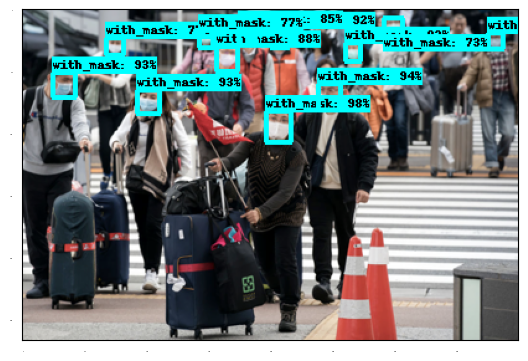

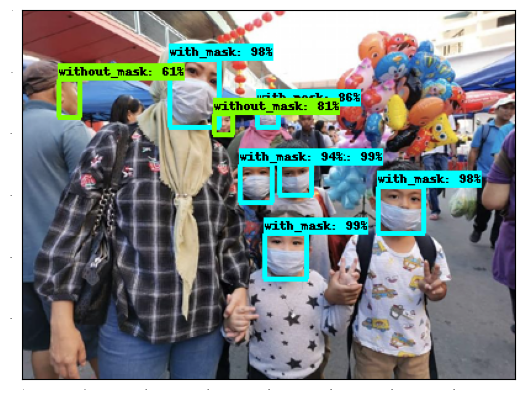

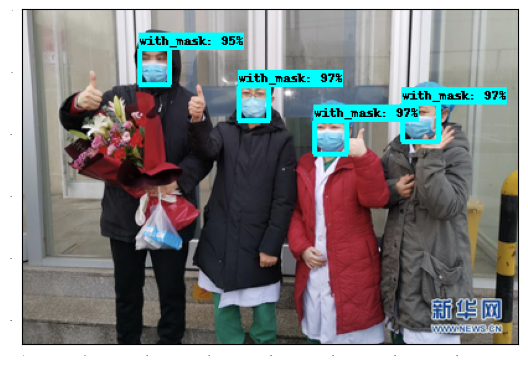

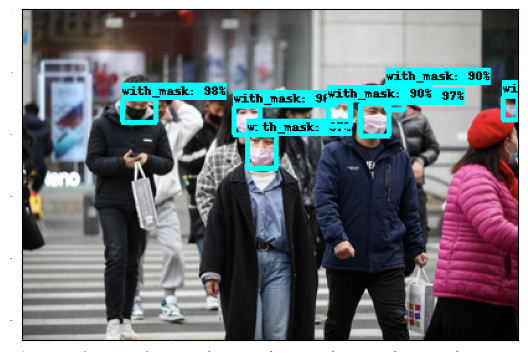

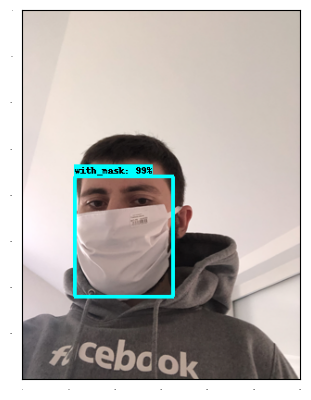

In [18]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False

for filename in np.random.choice(test_data['filename'].values, 5):
    image = cv2.imread(IMG_PATH + filename)
    image_np = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    boxes = detections['detection_boxes'][0].numpy()
    classes = (detections['detection_classes'][0].numpy()).astype(int)
    scores = detections['detection_scores'][0].numpy()
    plot_detections(image_np, boxes, classes, scores, category_index=category_index)